#IMPORTS

In [1]:
import nltk
import re

import pandas as pd
import numpy  as np

from nltk                            import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes             import MultinomialNB
from sklearn                         import svm
from sklearn                         import metrics
from sklearn.model_selection         import cross_val_predict
from nltk.tokenize                   import TweetTokenizer
from sklearn.pipeline                import Pipeline

##Help functions

In [2]:
def negation(texto):
    negacoes = ['não','not']
    negacao_detectada = False
    resultado = []
    palavras = texto.split()
    for p in palavras:
        p = p.lower()
        if negacao_detectada == True:
            p = p + '_NEG'
        if p in negacoes:
            negacao_detectada = True
        resultado.append(p)
    return (" ".join(resultado))

def model_performance(modelo, tweets, classes,model_name):
  resultados = cross_val_predict(modelo, tweets, classes, cv=10)
  return   pd.DataFrame({   'ModelName':model_name,                                     
                            'AccuracyCV': np.round(metrics.accuracy_score(classes,resultados),2).astype(str)  
                        },index=[0])

##Loading data

In [3]:
df = pd.read_csv('/content/Tweets_Mg.csv', encoding='utf-8')
df.head()

Unnamed: 0                      Created At  ... Unnamed: 23  Unnamed: 24
0           0  Sun Jan 08 01:22:05 +0000 2017  ...         NaN          NaN
1           1  Sun Jan 08 01:49:01 +0000 2017  ...         NaN          NaN
2           2  Sun Jan 08 01:01:46 +0000 2017  ...         NaN          NaN
3           3  Wed Jan 04 21:43:51 +0000 2017  ...         NaN          NaN
4           4  Mon Jan 09 15:08:21 +0000 2017  ...         NaN          NaN

[5 rows x 26 columns]

#DESCRIPTION OF DATA

##Rename columns

In [4]:
columns={'Classificacao':'Classification'}
df.rename(columns=columns,inplace=True)

#altering the classification
df['Classification']=df['Classification'].apply(lambda x: 'Positive' if x=='Positivo' else 
                                                          'Neutral' if x=='Neutro' else 
                                                          'Negative' if x=='Negativo' else x)

##Number of classes


In [5]:
df['Classification'].value_counts()

Positive    3300
Neutral     2453
Negative    2446
Name: Classification, dtype: int64

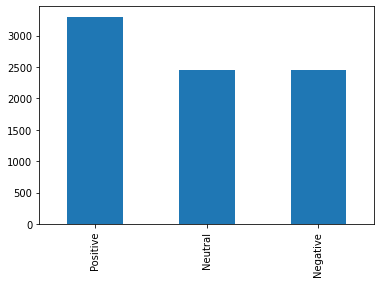

In [6]:
%matplotlib inline
df['Classification'].value_counts().plot(kind='bar')

##Data Dimensions

In [7]:
print('Number of rows: {}'.format(df.shape[0]))
print('Number of cols: {}'.format(df.shape[1]))

Number of rows: 8199
Number of cols: 26


#DATA PREPARATION

##Removing duplicate lines

In [8]:
df.drop_duplicates(['Text'], inplace=True)
df.Text.count()

5765

In [9]:
num_lines=df.shape[0]
num_lines_delete=num_lines-df.shape[0]
print('Number of deleted lines: {}'.format(num_lines_delete))

Number of deleted lines: 0


##Peparating the classes

In [10]:
tweets = df['Text']
classes = df['Classification']

##TweetTokenizer

In [11]:
tweet_tokenizer = TweetTokenizer()

#MACHINE LEARNING MODELS

In [12]:
#MultinomialNB
pipeline_MultinomialNB = Pipeline([
  ('counts', CountVectorizer()),
  ('classifier', MultinomialNB())
])

#MultinomialNB negation
pipeline_negation = Pipeline([
  ('counts', CountVectorizer(tokenizer=lambda text: negation(text))),
  ('classifier', MultinomialNB())
])

#SVC
pipeline_svm = Pipeline([
  ('counts', CountVectorizer()),
  ('classifier', svm.SVC(kernel='linear'))
])

#SVC negation
pipeline_svm_negation = Pipeline([
  ('counts', CountVectorizer(tokenizer=lambda text: negation(text))),
  ('classifier', svm.SVC(kernel='linear'))
])

In [14]:
#performance
pipeline_MultinomialNB_result=   model_performance(pipeline_MultinomialNB,  tweets, classes,'pipeline_MultinomialNB')
pipeline_negation_result=        model_performance(pipeline_negation,       tweets, classes,'pipeline_negation')
pipeline_svm_result=             model_performance(pipeline_svm,            tweets, classes,'pipeline_svm')
pipeline_svm_negation_result=    model_performance(pipeline_svm_negation,   tweets, classes,'pipeline_svm_negation')

modelling_results_cv=pd.concat([         pipeline_MultinomialNB_result,
                                         pipeline_negation_result,
                                         pipeline_svm_result,
                                         pipeline_svm_negation_result],axis=0)
#modelling_results_cv=modelling_results_cv[['ModelName','AccuracyCV']]
modelling_results_cv.sort_values('AccuracyCV',ascending=False)

ModelName AccuracyCV
0            pipeline_svm       0.89
0  pipeline_MultinomialNB       0.87
0   pipeline_svm_negation       0.77
0       pipeline_negation       0.68